# Lab 2.0: Hypothesis Testing

Question: Consider the peak flow time series for Skykomish River. Postulating a change in flood statistics around 1975, test for statistical significance of the observed change in the mean annual flood. 

Use a two-sample test, with alpha=0.05 (i.e. 95% confidence) and the z-distribution to define the rejection region (why is this appropriate?).

## Import and Sort Data
First, import modules for the whole lab and create useable arrays of data.

In [1]:
# Import all modules for the lab

# To load data
import pandas as pd

# To plot
import matplotlib.pyplot as plt
import numpy as np

import math
import scipy.stats as st
import statistics as stats
from scipy.interpolate import interp1d

%matplotlib inline

# Module with normal gaussian curve function.
# Since we don't need the entire scipy.stats library, we add "import norm" 
# to only import the norm function.
from scipy.stats import norm

In [2]:
# Define the location of the .xlsx file.
Skykomish_data_file = 'Skykomish_peak_flow_12134500_skykomish_river_near_gold_bar.xlsx'

# Use pandas.read_excel() function to open this file.
Skykomish_data = pd.read_excel(Skykomish_data_file)

# Now we can see the dataset we loaded:
Skykomish_data

,date of peak,water year,peak value (cfs),gage_ht (feet)
0,1928-10-09,1929,18800,10.55
1,1930-02-05,1930,15800,10.44
2,1931-01-28,1931,35100,14.08
3,1932-02-26,1932,83300,20.70
4,1932-11-13,1933,72500,19.50
...,...,...,...,...
76,2005-01-18,2005,74600,19.55
77,2005-12-24,2006,33800,14.27
78,2006-11-06,2007,129000,24.51
79,2007-12-03,2008,51100,16.79


In [3]:
# Divide the data into the early period (before 1975) and late period
# (after and including 1975). 
Skykomish_early = Skykomish_data[ Skykomish_data['water year'] < 1975 ] 
Skykomish_late = Skykomish_data[ Skykomish_data['water year'] >= 1975 ] 

## Find Distribution
Next, what kind of distribution does the data have?

(10000.0, 140000.0)

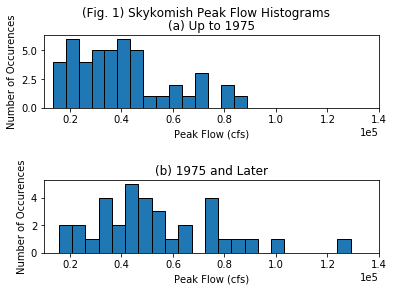

In [12]:
# Make a histogram for each period

bin_width = 0.5e4 # bin width in cfs

# Create a figure with subplots
fig1, axs = plt.subplots(2, 1)
fig1.subplots_adjust(hspace=1)
fig1.suptitle('(Fig. 1) Skykomish Peak Flow Histograms')

# set bin number so that intervals are equal in these two plots
nbins = int(( np.max(Skykomish_early['peak value (cfs)']) - np.min(Skykomish_early['peak value (cfs)']) ) / bin_width )
axs[0].hist(Skykomish_early['peak value (cfs)'], nbins, ec="black")
axs[0].set_title('(a) Up to 1975')
axs[0].set_xlabel('Peak Flow (cfs)')
axs[0].set_ylabel('Number of Occurences')
axs[0].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
axs[0].set_xlim((1e4,1.4e5))

# set bin number so that intervals are equal in these two plots
nbins = int(( np.max(Skykomish_late['peak value (cfs)']) - np.min(Skykomish_late['peak value (cfs)']) ) / bin_width )
axs[1].hist(Skykomish_late['peak value (cfs)'], nbins, ec="black")
axs[1].set_title('(b) 1975 and Later')
axs[1].set_xlabel('Peak Flow (cfs)')
axs[1].set_ylabel('Number of Occurences')
axs[1].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
axs[1].set_xlim((1e4,1.4e5))

Check which distribution might fit the data best by comparing this distribution of data to data you made up with a specified distribution.

* Try plotting theoretical cdfs with the distributions
you’re considering.

* Then, try generating a set of numbers from a
uniform distribution and a lognormal distribution
with the same mean and standard deviation as
the data (based on the histograms, the data does not look normal, but we can look at this as well).

* Create quantile plots of your generated numbers
to see how well they compare to your data and
your theoretical cdfs.

In [13]:
# Calculate CDF of the early data

# The function takes an array of data as an argument and returns an array of 
# evenly spaced intervals for the range of the data, the mean, and standard 
# deviation.
def make_cdf(data):
    
    mean = stats.mean(data)
    sd = stats.stdev(data)
    r = int(np.max(data)-np.min(data))
    # this counts the nunber of integers from the highest to the lowest value
    
    return np.linspace(np.min(data), np.max(data), r), mean, sd

# run this function on the early period of peak flow values
range_early, mean_early, sd_early = make_cdf(Skykomish_early['peak value (cfs)'])

In [14]:
# Calculate quantiles of the early data

# The function takes an array of data as an argument and returns the data
# as an ordered array and the plotting position associated with each data point.
def quantile_fn(data):

    ordered_data = np.sort(data)
    n = len(ordered_data)

    rank = []
    plotting_position = []
    for i in range(n):
        rank.append(i+1)
        # Using the Cunnane plotting position.
        plotting_position.append((rank[i]-.4)/(n+.2))
        
    return ordered_data, plotting_position


# run this function on the early period of peak flow values
ordered_early, plotting_early = quantile_fn(Skykomish_early['peak value (cfs)'])

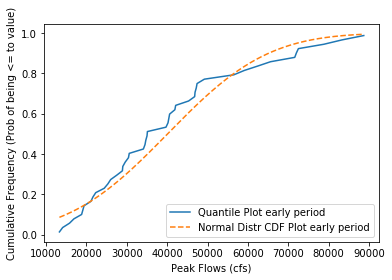

In [25]:
# Now, make a plot of these
plt.figure(2)
plt.plot(ordered_early, plotting_early, label="Quantile Plot early period")
#plt.plot(norm.cdf(ordered_Skykomish, mean, sd), color='orange', label='Normal Distribution CDF Plot')
plt.plot(range_early,norm.cdf(range_early, mean_early, sd_early), '--', label='Normal Distr CDF Plot early period')
plt.xlabel('Peak Flows (cfs)')
plt.ylabel('Cumulative Frequency (Prob of being <= to value)')
plt.legend(loc="best")

The above graph definitely looks like the data are _not_ normally distributed.

### Lognormal Distribution

In [22]:
# Try lognormal distribution for the early period

mu_early = math.log(mean_early**2 / math.sqrt(mean_early**2 + sd_early**2))
sigma_early = math.sqrt(math.log((mean_early**2 + sd_early**2) / (mean_early**2)))
size = Skykomish_early['peak value (cfs)'].size

early_lognormal = np.random.lognormal(mu_early, sigma_early, size)

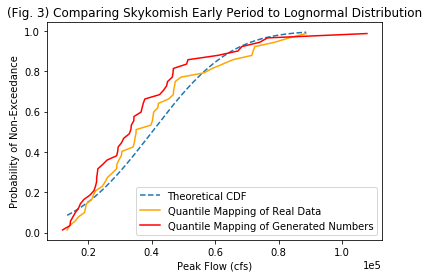

In [24]:
# Plot and compare the theoretical CDF, quantile plot of data, and quantile plot
# of generated lognormal data

ordered_lognormal, plotting_lognormal = quantile_fn(early_lognormal)

plt.figure(3)

plt.plot(range_early, st.norm.cdf(range_early, mean_early, sd_early), '--', label='Theoretical CDF')
plt.plot(ordered_early, plotting_early, color='orange', label='Quantile Mapping of Real Data')
plt.plot(ordered_lognormal, plotting_lognormal, color='red', label='Quantile Mapping of Generated Numbers')

plt.title('(Fig. 3) Comparing Skykomish Early Period to Lognormal Distribution')
plt.xlabel('Peak Flow (cfs)')
plt.ylabel('Probability of Non-Exceedance')
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.legend(loc="best")

Lognormal looks like a fair approximation, although it may not be exactly right.

## Z-Distribution
### Return to our question, what are we trying to do?  We are postulating (making a hypothesis) that there was a change in the mean flood statistics after 1975, and we want to test whether this is true.  Where do we start?
First, we need to create a null and an alternative hypothesis.  We were told to use a two sample test, and to set $\alpha$ at 5%.

$H_0: \mu_{early} = \mu_{late}$

$H_1: \mu_{late} > \mu_{early}$

Note that I have written a one-sided test here.  We think that either the mean flood increased or it didn't change; we do not think the mean flood decreased.  This might be chosen because we have some physical reason to think it increased (maybe it's raining at higher elevations now when it used to be snowing) or because we have some practical reason for the test to matter in this particular direction (maybe we will change flood zoning and/or reservoir levels if the mean flood has increased but don't care at all if it decreased).

### But which test should we use?  Is the z-distribution valid?
Remember, the z-distribution refers to the standard-normal distribution.
From our work above, we know that our data are _not_ normally distributed.
However, the central limit theorem states, "If a sample of n values is extracted at random from a population with mean  μ and standard deviation σ, and n > 30, then the means of these samples are approximately normally distributed"

#### Remember, the means are normally distributed even if the data themselves are not normally distributed.

In [26]:
# Check that we have a large enough sample size (n>30)
n = len(Skykomish_early['peak value (cfs)'])
m = len(Skykomish_late['peak value (cfs)'])
print(n)
print(m)

46
35


In [27]:
# We're okay, both are longer than 30, so Calculate the z-test, p-value

# if alpha is set at 0.5, the confidence is 1-alpha:
conf = 0.95

# Out null hypothesis is no change, so mu_late - mu_early = 0
delta_0 = 0

# We determine which value in the z-distribution corresponds to 0.95 in the cdf
z_alpha = st.norm.ppf(conf)
print("z_alpha =") 
print(z_alpha)

mean1 = stats.mean(Skykomish_early['peak value (cfs)'])
mean2 = stats.mean(Skykomish_late['peak value (cfs)'])

sd1 = stats.stdev(Skykomish_early['peak value (cfs)'])
sd2 = stats.stdev(Skykomish_late['peak value (cfs)'])

pooled_sd = math.sqrt(sd1**2/m + sd2**2/n)

ztest = (mean2 - mean1 - delta_0)/pooled_sd

print("z_test =") 
print(ztest)
p = 1 - st.norm.cdf(ztest)
print("p = ")
print(p)

z_alpha =
1.6448536269514722
z_test =
2.797962599761196
p = 
0.0025713033496177484


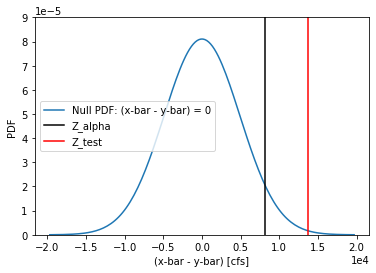

In [28]:
# Plot the results

plt.figure()

x = np.linspace(-4, 4, num=160)
x = [i * pooled_sd for i in x]

plt.plot(x, st.norm.pdf(x, 0, pooled_sd), label='Null PDF: (x-bar - y-bar) = 0')
plt.axvline(z_alpha*pooled_sd, color='black', label='Z_alpha')
plt.axvline(ztest*pooled_sd, color='red', label='Z_test')
plt.xlabel('(x-bar - y-bar) [cfs]')
plt.ylabel('PDF')
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.ylim(0, 9e-5)
plt.legend(loc='best')

### How would the estimate of p change if the null hypothesis is that the difference in the means is equal to 10% of the mean of the early period, and the alternative hypothesis is that greater than a 10% change occurred?

In [29]:
# Calculate the z-test, p-value

# Now, our change is not 0.  Now we think mu_late - mu_early = 0.10*mu_early
delta = .1 * mean1

z_alpha_2 = st.norm.ppf(conf, delta, pooled_sd)
# Note that this one is different from the one aboee because the delta and sd are
# included in the function

ztest2 = (mean2 - mean1 - delta)/pooled_sd

p_2 = 1 - st.norm.cdf(ztest)

print(z_alpha_2, ztest2, ztest2*pooled_sd)

12109.335493586073 1.9828654179778578 9760.838509316765


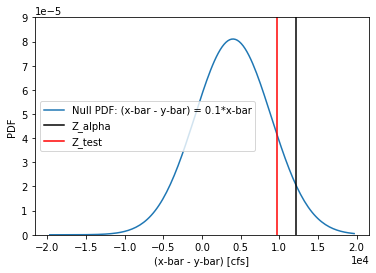

In [30]:
# Plot the results

plt.figure()

plt.plot(x, st.norm.pdf(x, delta, pooled_sd), label='Null PDF: (x-bar - y-bar) = 0.1*x-bar')
plt.axvline(z_alpha_2, color='black', label='Z_alpha')
plt.axvline(ztest2*pooled_sd, color='red', label='Z_test')
plt.xlabel('(x-bar - y-bar) [cfs]')
plt.ylabel('PDF')
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.ylim(0, 9e-5)
plt.legend(loc='best')

## So what happened up above?
We created a more stringent test.  Say, for example, that we only would raise levees if the mean flood (defined by the annual peak flow) increased by more than 10%.  While we are 95% sure that there is a change greater than 0; we are _not_ 95% sure that the change is greater than 10% of the early period mean.